In [1]:
#For Now I am strictly following the offical tensorflow guide to linear regression: https://www.youtube.com/watch?v=-vHQub0NXI4
#This is becuse I want to make sure I'm not screwing anything up; I will experiment later once I get this to work

In [2]:
import pathlib
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
 
import nba_api
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import playercareerstats, leaguegamefinder, playerdashboardbyclutch, playergamelogs, commonplayerinfo, teamplayeronoffdetails, teamgamelogs
import pandas as pd

In [3]:
class Player(object):
    def __init__(self, PlayerID, TeamID):
        
        self.PlayerID =  PlayerID 
        self.PlayerName = players.find_player_by_id(player_id=self.PlayerID)['full_name']

        self.StartYear = commonplayerinfo.CommonPlayerInfo(player_id= self.PlayerID).get_data_frames()[0]['FROM_YEAR'][0] 
        if self.StartYear < 2010:
            self.StartYear = 2010
            
        self.LastYear = 2021
        self.TeamID = TeamID

    def compile_active_player_data(self):
        
        player_name = []
        points_scored_raw_data=[]
        game_date_raw_data = []
        win_loss_raw_data = []
        free_throws_raw_data = [] 
        feild_goals_2pts_raw_data = []
        feild_goals_3pts_raw_data = []
        matchup_raw_data = []
        location = []
        team_season_point_average_raw_data = []
        opponent_team_average_raw_data = []
        print(self.StartYear, self.LastYear)
        for year in range((self.StartYear), (self.LastYear)):
            print("-------------------------------------------------")
            season = str(year) + "-" + str(((year+1)-2000))
            playerLogs = playergamelogs.PlayerGameLogs(player_id_nullable=self.PlayerID, season_nullable=season)
            print(season)
            
            game_date_api_data = playerLogs.get_data_frames()[0]["GAME_DATE"]
            win_loss_api_data = playerLogs.get_data_frames()[0]["WL"]
            free_throws_api_data = playerLogs.get_data_frames()[0]["FTM"]
            feild_goals_2pts_api_data = playerLogs.get_data_frames()[0]["FGM"]
            feild_goals_3pts_api_data = playerLogs.get_data_frames()[0]["FG3M"] 
            matchup_api_data = playerLogs.get_data_frames()[0]["MATCHUP"]


            
            
            team_free_throws_average_api_data = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season).get_data_frames()[0]["FTM"].mean()
            team_feild_goals_2pts_average_api_data = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season).get_data_frames()[0]["FGM"].mean()
            team_feild_goals_3pts_average_api_data = teamgamelogs.TeamGameLogs(team_id_nullable=self.TeamID, season_nullable=season).get_data_frames()[0]["FG3M"].mean()
            team_season_point_average_api_data = ((team_free_throws_average_api_data) + (team_feild_goals_2pts_average_api_data*2) + (team_feild_goals_3pts_average_api_data*3))


            for game in range(0, len(game_date_api_data)):
                    player_name.append(self.PlayerName)
                    game_date_raw_data.append(game_date_api_data[game])
                    win_loss_raw_data.append(win_loss_api_data[game])
                    #free_throws_raw_data.append(free_throws_api_data[game]) 
                    #feild_goals_2pts_raw_data.append(feild_goals_2pts_api_data[game])
                    #feild_goals_3pts_raw_data.append(feild_goals_3pts_api_data[game])
                    points_scored_raw_data.append((free_throws_api_data[game])+(feild_goals_2pts_api_data[game]*2)+(feild_goals_3pts_api_data[game]*3))
                    matchup_raw_data.append(matchup_api_data[game])
                    location.append(0)
                    team_season_point_average_raw_data.append(team_season_point_average_api_data)

        
        player_data = {
        "Player Name": player_name,
        "Points Scored": points_scored_raw_data,
        "Game Date": game_date_raw_data,
        "Win/Loss": win_loss_raw_data,
        #"Free Throws": free_throws_raw_data,
        #"Feild Goals 2pts": feild_goals_2pts_raw_data,
        #"Feild Goals 3pts": feild_goals_3pts_raw_data,
        "Matchup": matchup_raw_data,
        "Location": location,
        "Team Point Average" : team_season_point_average_raw_data
        }

        player_dataFrame = pd.DataFrame(data=player_data)
        print(player_dataFrame)

        return(player_dataFrame)


    def get_active_player_data(self):
        return(self.compile_active_player_data())



In [4]:
teams = {
    "ATL": 1,
    "BKN": 2,
    "BOS": 3,
    "CHA": 4,
    "CHI": 5,
    "CLE": 6,
    "DAL": 7,	
    "DEN": 8,
    "DET": 9,
    "GSW": 10,	
    "HOU": 11,	
    "IND": 12,
    "LAC": 13,	
    "LAL": 14,	
    "MEM": 15, 	
    "MIA": 16,	
    "MIL": 17,	
    "MIN": 18,	
    "NOP": 19,
    "NOH": 19,	
    "NYK": 20,	
    "OKC": 21,	
    "ORL": 22,	
    "PHI": 23,	
    "PHX": 24,	
    "POR": 25,	
    "SAC": 26,	
    "SAS": 27,	
    "TOR": 28,	
    "UTA": 29,	
    "WAS": 30
}

In [14]:
#Data Preparation

test = Player(203081, 1610612757).get_active_player_data()

for i in range(0, len(test)):

    if ((i%10)==0):
        print("Processing Game Number:", i, "/" ,len(test))

    if test["Win/Loss"][i] == "W":
           test["Win/Loss"][i] = 1 
    if test["Win/Loss"][i] == "L":
           test["Win/Loss"][i] = 2
    matchup = test["Matchup"][i]
    if " vs. " in matchup:
        test["Location"][i] = 1
    if "@" in matchup:
        test["Location"][i] = 2
    try:   
        matchup = matchup.replace('POR', "")
    except:
        print("Unexpected Error with removing player team")
    try:
        matchup = matchup.replace(" @ ", "")
        matchup = matchup.replace(" vs. ", "")
    except:
        print("Error")
    
    
    test['Matchup'][i]=teams[matchup]


    
opponent = test.pop('Matchup')

test["ATL"] = (opponent == 1)*1.0
test["BKN"] = (opponent == 2)*1.0
test["BOS"] = (opponent == 3)*1.0
test["CHA"] = (opponent == 4)*1.0
test["CHI"] = (opponent == 5)*1.0
test["CLE"] = (opponent == 6)*1.0
test["DAL"] = (opponent == 7)*1.0
test["DEN"] = (opponent == 8)*1.0
test["DET"] = (opponent == 9)*1.0
test["GSW"] = (opponent == 10)*1.0
test["HOU"] = (opponent == 11)*1.0
test["IND"] = (opponent == 12)*1.0
test["LAC"] = (opponent == 13)*1.0
test["LAL"] = (opponent == 14)*1.0
test["MEM"] = (opponent == 15)*1.0
test["MIA"] = (opponent == 16)*1.0
test["MIL"] = (opponent == 17)*1.0
test["MIN"] = (opponent == 18)*1.0
test["NOP"] = (opponent == 19)*1.0
test["NYK"] = (opponent == 20)*1.0
test["OKC"] = (opponent == 21)*1.0
test["ORL"] = (opponent == 22)*1.0
test["PHI"] = (opponent == 23)*1.0
test["PHX"] = (opponent == 24)*1.0
test["POR"] = (opponent == 25)*1.0
test["SAC"] = (opponent == 26)*1.0
test["SAS"] = (opponent == 27)*1.0
test["TOR"] = (opponent == 28)*1.0
test["UTA"] = (opponent == 29)*1.0
test["WAS"] = (opponent == 30)*1.0		



location = test.pop("Location")

test["Home"] = (location == 1)*1.0
test["Away"] = (location == 2)*1.0

outcome = test.pop("Win/Loss")
test["Win"] = (outcome == 1)*1.0
test["Loss"] = (outcome == 2)*1.0


test    



test = test.drop(columns=["Player Name", "Game Date"])


print(test)




2012 2021
-------------------------------------------------
2012-13
-------------------------------------------------
2013-14
-------------------------------------------------
2014-15
-------------------------------------------------
2015-16
-------------------------------------------------
2016-17
-------------------------------------------------
2017-18
-------------------------------------------------
2018-19
-------------------------------------------------
2019-20
-------------------------------------------------
2020-21
        Player Name  Points Scored            Game Date Win/Loss      Matchup  \
0    Damian Lillard             25  2013-04-17T00:00:00        L  POR vs. GSW   
1    Damian Lillard             16  2013-04-16T00:00:00        L    POR @ LAC   
2    Damian Lillard             38  2013-04-14T00:00:00        L    POR @ DEN   
3    Damian Lillard             12  2013-04-12T00:00:00        L  POR vs. OKC   
4    Damian Lillard             48  2013-04-10T00:00:00        

In [15]:
train_dataset = test.sample(frac=0.8, random_state=0)
test_dataset = test.drop(train_dataset.index)
train_dataset = train_dataset.drop(columns=["POR"])
test_dataset = test_dataset.drop(columns=["POR"])

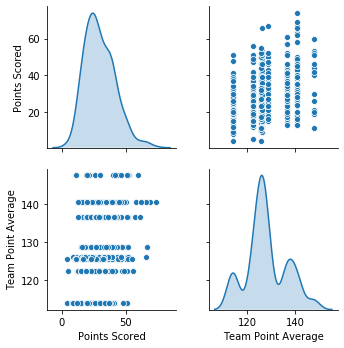

In [16]:
sns.pairplot(train_dataset[["Points Scored", "Team Point Average"]], diag_kind="kde" )

In [17]:
train_stats = train_dataset.describe()
train_stats.pop("Points Scored")
train_stats = train_stats.transpose()
train_stats

#for this data this is not that informative but the mean gives a good impression of the number of times Damian Lillard had played the shown team

,count,mean,std,min,25%,50%,75%,max
Team Point Average,508.0,127.936957,8.381358,113.914634,122.47561,126.231707,136.707317,147.7
ATL,508.0,0.021654,0.145693,0.000000,0.00000,0.000000,0.000000,1.0
BKN,508.0,0.023622,0.152018,0.000000,0.00000,0.000000,0.000000,1.0
BOS,508.0,0.027559,0.163867,0.000000,0.00000,0.000000,0.000000,1.0
CHA,508.0,0.021654,0.145693,0.000000,0.00000,0.000000,0.000000,1.0
CHI,508.0,0.021654,0.145693,0.000000,0.00000,0.000000,0.000000,1.0
CLE,508.0,0.023622,0.152018,0.000000,0.00000,0.000000,0.000000,1.0
DAL,508.0,0.047244,0.212370,0.000000,0.00000,0.000000,0.000000,1.0
DEN,508.0,0.051181,0.220584,0.000000,0.00000,0.000000,0.000000,1.0
DET,508.0,0.021654,0.145693,0.000000,0.00000,0.000000,0.000000,1.0


In [18]:
train_labels = train_dataset.pop("Points Scored")
test_labels = test_dataset.pop("Points Scored")

In [19]:

def sigmoid(x):
    return(x - train_stats['mean'])/train_stats['std']
normed_train_data = sigmoid(train_dataset)
normed_test_data = sigmoid(test_dataset)


In [20]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [21]:
model = build_model()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2240      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [23]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.4964766 ],
       [-0.5100138 ],
       [-0.31946096],
       [-0.21766707],
       [-0.5033988 ],
       [ 0.4120428 ],
       [-0.17012674],
       [-0.10499206],
       [ 0.02412268],
       [-1.1668048 ]], dtype=float32)

In [24]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split= 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,28.786140,3.093064,28.786140,232.738159,12.723741,232.738159,995
996,28.719599,3.149342,28.719599,230.617661,12.574043,230.617661,996
997,29.081184,3.114898,29.081184,234.670303,12.733361,234.670303,997
998,28.523993,3.094771,28.523993,229.219299,12.588101,229.219299,998
999,28.663296,3.051868,28.663296,235.285522,12.784216,235.285522,999


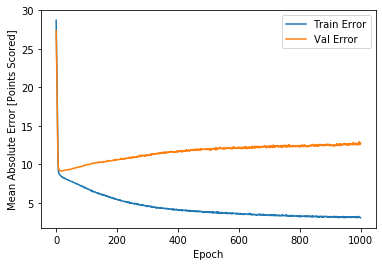

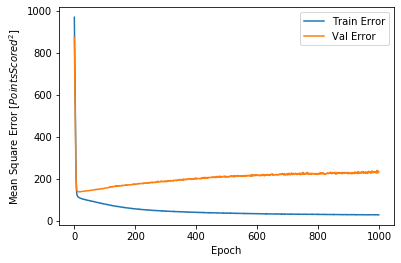

In [33]:
import matplotlib.pyplot as plt 

def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error [Points Scored]")
    plt.plot(hist['epoch'], hist['mae'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mae'], label="Val Error")

    plt.legend()
    #plt.ylim([0,5])


    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$Points Scored^2$]")
    plt.plot(hist['epoch'], hist['mse'], label="Train Error")
    plt.plot(hist['epoch'], hist['val_mse'], label="Val Error")
    plt.legend()
    #plt.ylim([0,20])

plot_history(history)


..................

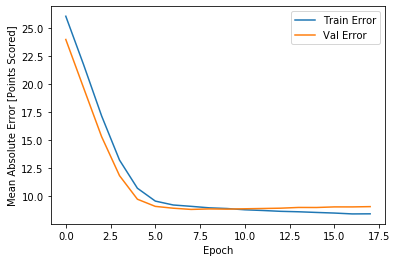

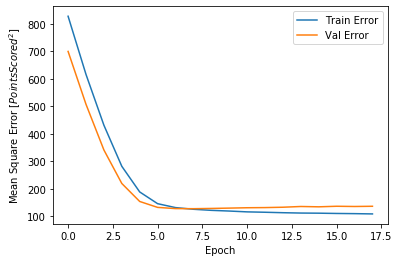

In [36]:
#early stopping

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Points Scored".format(mae))

Testing set Mean Abs Error:  9.52 Points Scored


(0, 99.41300729185299)

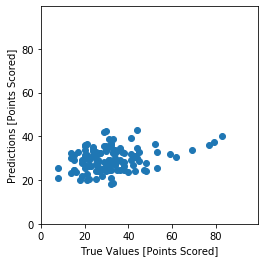

In [40]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [Points Scored]")
plt.ylabel("Predictions [Points Scored]")
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.ylim()[1]])
plt.ylim([0, plt.ylim()[1]])
#_ = plt.plot([-100,100], [-100, 100])